In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import ast
from advisor_client.client import *
client = AdvisorClient()

In [18]:
# get study
study_name = "optimal_jump1"
study = client.get_study_by_name(study_name)
print(study)

Id: 1, name: optimal_jump1, study_configuration: {"randomInitTrials": 20, "params": [{"parameterName": "jump_a", "type": "DOUBLE", "maxValue": 5.0, "minValue": -5.0}, {"parameterName": "jump_b", "type": "DOUBLE", "maxValue": 5.0, "minValue": -5.0}, {"parameterName": "jump_c", "type": "DOUBLE", "maxValue": 5.0, "minValue": -5.0}, {"parameterName": "jump_d", "type": "DOUBLE", "maxValue": 3.5, "minValue": 0}, {"parameterName": "opt_vel", "type": "DOUBLE", "maxValue": 6.0, "minValue": 2.0}], "goal": "MINIMIZE"}, algorithm: BayesianOptimization


In [19]:
# plot training Loss vs Epoch
train_curve = []
train_param = []
trials = client.list_trials(study_name)

for trial in trials:
    trial_metrics = client.list_trial_metrics(study_name,trial.id)
    train_param.append(ast.literal_eval(trial.parameter_values)) # string to dictionary
    for metrics in trial_metrics:
        train_curve.append(metrics.objective_value)

for param,objval in zip(train_param,train_curve):
    param["objective_value"] = objval

train_curve = np.array(train_curve)

In [30]:
save_fig = True

Best epoch: 99
Best objval: 9.953
Best trial: {'opt_vel': 2.4510971061471922, 'objective_value': 9.95308138004, 'jump_d': 2.5745559244854648, 'jump_c': 3.3526312914223073, 'jump_b': -3.6767745778012206, 'jump_a': 0.31170989649604763}


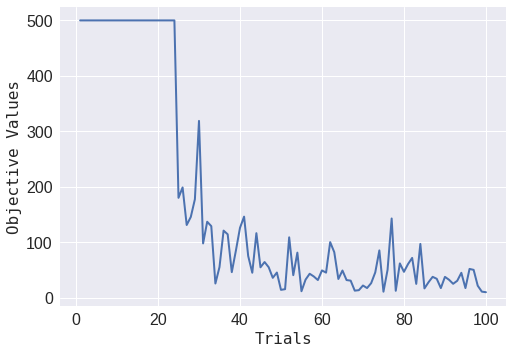

In [38]:
scale = 500
font = {'family': 'monospace',
        'weight': 'normal',
        'size': 16,
        }
train_curve_clip = np.clip(train_curve,0,scale)
best_idx = np.argmin(train_curve)
best_objval = round(train_curve[best_idx],3)
# print("Is study done: %r"%client.is_study_done(study_name))
print("Best epoch: %d"%best_idx)
print("Best objval: %.3f"%best_objval)
print("Best trial: {}".format(train_param[best_idx]))
plt.style.use('seaborn')
plt.plot(range(1,len(train_curve)+1),train_curve_clip,linewidth=2)
plt.xlabel("Trials",fontdict=font)
plt.ylabel("Objective Values",fontdict=font)
plt.xticks(fontsize=font["size"])
plt.yticks(fontsize=font["size"])
if save_fig:
    plt.savefig("./records/objval_"+str(best_objval)+"_"+str(scale)+".png")
plt.show()

max objval: 27.987
{'opt_vel': 2.4510971061471922, 'objective_value': 9.95308138004, 'jump_d': 2.5745559244854648, 'jump_c': 3.3526312914223073, 'jump_b': -3.6767745778012206, 'jump_a': 0.31170989649604763}
{'opt_vel': 2.4341007574959588, 'objective_value': 10.9068976337, 'jump_d': 3.406124917209566, 'jump_c': 3.0482766793789864, 'jump_b': -4.685607386463603, 'jump_a': 0.31403372165573185}
{'opt_vel': 2.458242178310357, 'objective_value': 10.969862828, 'jump_d': 3.4533539637775137, 'jump_c': 3.095761034240411, 'jump_b': -4.7158785219995645, 'jump_a': 0.33033237126736115}
{'opt_vel': 2.434279654305911, 'objective_value': 11.7253827322, 'jump_d': 2.486106348585756, 'jump_c': 3.031374653984386, 'jump_b': -3.790678230704766, 'jump_a': 0.2030486185691771}
{'opt_vel': 2.445952732936544, 'objective_value': 12.5227352739, 'jump_d': 3.340561414314088, 'jump_c': 3.1764425837661427, 'jump_b': -4.568821611582541, 'jump_a': 0.07458238639392256}
{'opt_vel': 2.3962579700967073, 'objective_value': 12.

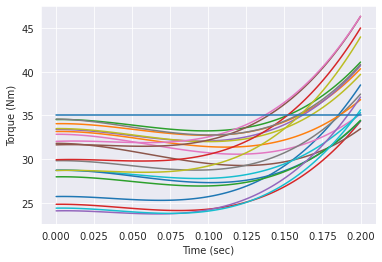

In [16]:
topk_idx = np.argsort(train_curve)[:20] # sort top n minimial index
print("max objval: %.3f"%np.max(train_curve[topk_idx]))
t = np.linspace(0,0.2,100)
y_constant = 35*np.ones_like(t)
for idx in topk_idx:
    param = train_param[idx]
    print(param)
    a = param["jump_a"]
    b = param["jump_b"]
    c = param["jump_c"]
    d = param["jump_d"]
    y_poly = 10*a * t + 100*b * t**2 + 1000*c * t**3 + 10*d
    plt.plot(t,y_poly)
plt.plot(t,y_constant)
plt.xlabel("Time (sec)")
plt.ylabel("Torque (Nm)")
if save_fig:
    plt.savefig("./records/torque_"+str(best_objval)+".png")
plt.show()

In [34]:
# display top n trials in webots
top_n = 2
for count,idx in zip(range(top_n),topk_idx[:top_n]):
    param_dic = train_param[idx]
    print(param_dic)
    with open("./controllers/my_controller_python/args.txt",'w') as f11:
        f11.write(str(param_dic))

    os.system("webots --mode=pause")

    with open("./controllers/my_controller_python/metrics.txt",'r') as f22:
        metrics_dic = eval(f22.read())
        y = metrics_dic["jump_metrics"]
        
    print("top %d, real_obj: %.3f, train_obj: %.3f"%(count,y,float(param_dic["objective_value"])))

{'opt_vel': 2.4510971061471922, 'objective_value': 9.95308138004, 'jump_d': 2.5745559244854648, 'jump_c': 3.3526312914223073, 'jump_b': -3.6767745778012206, 'jump_a': 0.31170989649604763}
top 0, real_obj: 14.154, train_obj: 9.953
{'opt_vel': 2.4341007574959588, 'objective_value': 10.9068976337, 'jump_d': 3.406124917209566, 'jump_c': 3.0482766793789864, 'jump_b': -4.685607386463603, 'jump_a': 0.31403372165573185}
top 1, real_obj: 15.270, train_obj: 10.907


In [9]:
# save dicts to txt
with open("./records/args_"+str(best_objval)+".txt",'w') as arts_txt:
    for param_dict in train_param:
        arts_txt.write(str(param_dict)+"\n") # one dictionary per line

In [10]:
# save dicts to csv
import csv
with open("./records/args_"+str(best_objval)+".csv",'w') as args_csv:
    w = csv.DictWriter(args_csv,train_param[0].keys())
    w.writeheader()
    for param_dict in train_param:
        w.writerow(param_dict)

In [13]:
# read from txt
train_param = []
train_curve = []
with open("./records/args_9.953.txt",'r') as arts_txt:
    lines = arts_txt.readlines()
    for line in lines:
        train_param.append(eval(line))
        train_curve.append(train_param[-1]["objective_value"])
train_curve = np.asarray(train_curve)

In [12]:
# read from csv
train_param = []
train_curve = []
with open("./records/args_20.788.csv",'r') as args_csv:
    dict_reader = csv.DictReader(args_csv)
    for param_dict in dict_reader:
        train_param.append(param_dict)
        train_curve.append(train_param[-1]["objective_value"])
train_curve = np.asarray(train_curve)

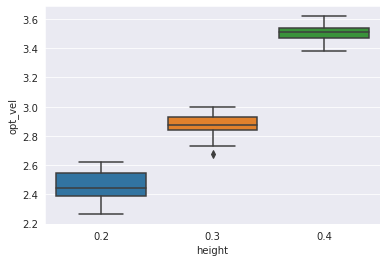

In [20]:
# box plot from h = 0.2/0.3/0.4
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv("./records/boxplot.csv")
# boxplot = df.boxplot(by ='height', column =['opt_vel'], grid = False)
sns.set_style("darkgrid")
ax = sns.boxplot(data=df,x="height",y="opt_vel")

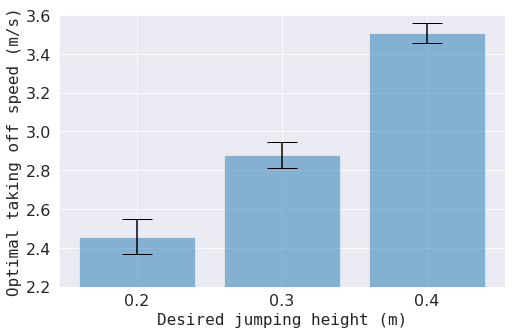

In [7]:
data = np.asarray(df["opt_vel"])
x_ticks = np.unique(np.asarray(df["height"]))
h2_mean = data[:50].mean()
h3_mean = data[50:100].mean()
h4_mean = data[100:150].mean()
values = [h2_mean,h3_mean,h4_mean]

h2_std = data[:50].std()
h3_std = data[50:100].std()
h4_std = data[100:150].std()
stds = [h2_std,h3_std,h4_std]

fig,ax = plt.subplots(figsize=(8,5))
ax.bar(np.arange(3), values, yerr = stds, align='center', ecolor='black', capsize=15, alpha=0.5)
ax.set_ylabel('Optimal taking off speed (m/s)',fontdict=font)
ax.set_xlabel("Desired jumping height (m)",fontdict=font)
ax.set_xticks(np.arange(3))
ax.tick_params(axis="y", labelsize=font["size"])
ax.set_xticklabels(x_ticks,fontsize=font["size"])
ax.set_ylim([2.2,3.6])
ax.yaxis.grid(True)
if save_fig:
    plt.savefig("./records/opt_vel.png")
plt.show()

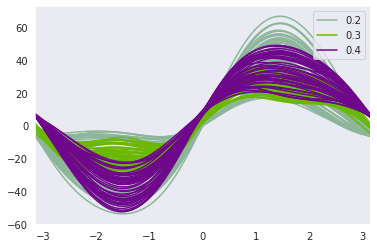

In [21]:
# df = pd.read_csv("./records/args_20.788.csv")
andrews_curves = pd.plotting.andrews_curves(df, 'height')
andrews_curves.plot()
plt.show()